In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import sys
from numba import cuda
import math
from typing import Sequence
import copy

In [2]:
def generate_lattice(n, m):
    lattice = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            lattice[i, j] = np.random.randint(2)
    return lattice

def color_clusters(lattice):
    m, n = lattice.shape
    colors = np.zeros((m, n))
    current_color = 1
    for i in range(m):
        for j in range(n):
            if lattice[i, j] == 1:
                neighbors = []
                if i > 0:
                    if colors[i-1,j] != 0:
                         neighbors.append(colors[i - 1, j])
                        
                if j > 0:
                    if colors[i,j-1] != 0:
                        neighbors.append(colors[i, j - 1])
                if not neighbors:
                    colors[i, j] = current_color
                    current_color += 1
                else:
                    colors[i, j] = min(neighbors)
                    for neighbor in neighbors:
                        if neighbor != colors[i, j]:
                            colors[colors == neighbor] = colors[i, j]
    return colors


def largestAndSecondLargestCluster(lattice):
    if np.all(lattice==np.zeros(lattice.shape)):
        return (0,0)
    elif np.all(lattice==np.ones(lattice.shape)):
        return (np.size(lattice),0)
    else:
        
        colors = color_clusters(lattice)
        unique, counts = np.unique(colors, return_counts=True)
        counts = dict(zip(unique, counts))
        del counts[0]
        largest = max(counts.values())
        del counts[max(counts, key=counts.get)]
        secondLargest = max(counts.values())
        return largest,secondLargest
    
        

In [3]:
lattice = (np.random.random((32,32)) < 0.5).astype(np.int64)
print(largestAndSecondLargestCluster(lattice))

(59, 51)


In [4]:
@njit
def applyK(input,kernel,l):
    l = input.shape[0]
    output = np.zeros(input.shape)
    for x in range(input.shape[0]):
        for y in range(input.shape[1]):
            for i in range(3):
                for j in range(3):
                    output[x,y] += input[(x-1 + i)%l,(y-1 + j )%l] * kernel[i,j]
                    
    return output
        

In [5]:
@njit
def getBenefits(strategies,magnificationFactor,l):
    
    kernel = np.array([[0,1,0],[1,1,1],[0,1,0]],dtype=np.float64)

    groupValues = applyK(strategies/5,kernel,l)
    benefits = applyK(groupValues*magnificationFactor/5,kernel,l)
    
    
#1     
    return benefits-strategies+1

In [6]:
@njit
def getUpdatingFactors(beta,benefits,alternativeBenefits):
    return 1/(1+np.exp(beta*(benefits-alternativeBenefits)))   # not only the present benefit but the memory of the present strat
    

@njit
def getUpdatingResults(updatingFactors,l):
    return np.random.uniform(0,1,size=(l,l))< updatingFactors

In [7]:
@njit
def updateStrategy(strategies,alternativeStrategies,updatingResults):
    return (1-updatingResults)*strategies + updatingResults*alternativeStrategies  #np.where

In [8]:
@njit
def getIndexMatrix(l): 
    indexLattice = np.zeros((l,l,2),dtype=np.int64)
    for i in range(l):
        for j in range(l):
            indexLattice[i,j] = i,j
            
    return indexLattice

In [9]:
walks = np.array([0+1J,1,-1,0-1J])

In [10]:
@njit
def updateMemory(strategies,benefits,memory,m,l):
    meanMemory = np.zeros((memory.shape[0],memory.shape[1],2))   
    for i in range(memory.shape[2]):
        meanMemory += memory[:,:,i,:]
    meanMemory /= memory.shape[2]
    
    kernel = np.array([[0,1,0],[1,1,1],[0,1,0]],dtype=np.float64)
    # n1 =  applyK(strategies,kernel)
    # n0 = applyK((1-strategies),kernel)
    n1 = strategies
    n0 = 1-strategies
    
    
    
    # events1 = applyK(strategies*benefits,kernel) /n1
    # events0 = applyK((1-strategies)*benefits,kernel) /n0
    
    events1 = (strategies*benefits)/n1
    events0 = ((1-strategies)*benefits)/n0
    
    events0 = np.where(n0==0,meanMemory[:,:,0],events0)
    events1 = np.where(n1==0,meanMemory[:,:,1],events1)



    events = np.concatenate((events0.reshape((l,l,1,1)),events1.reshape((l,l,1,1))),axis=3)
    memory = np.concatenate((memory,events),axis=2)




    return memory[:,:,-m:,:]


In [11]:
def stepLogic(strategies,record,memory,m,t,b,beta,l):
    #trade
    benefits = getBenefits(strategies,b,l)
    #update memory
    
    record[:,:,t,0] = strategies
    record[:,:,t,1] = benefits

    #update strategy 
    
    memory = updateMemory(strategies,benefits,memory,m,l)
    
    meanBenefits,alternativeStrategies,alternativeBenefits = getAlternativesLogic(strategies,memory,l)
    
    updatingResults = getUpdatingResults(getUpdatingFactors(beta,meanBenefits,alternativeBenefits),l)
    new_strategies = updateStrategy(strategies,alternativeStrategies,updatingResults)
    
    return new_strategies,record,memory

In [12]:
def getAlternativesLogic(strategies,memory,l):
    meanMemory = np.zeros((memory.shape[0],memory.shape[1],2))   
    for i in range(memory.shape[2]):
        meanMemory += memory[:,:,i,:]
    meanMemory /= memory.shape[2]
        
        
        
    neighborIndexes = np.zeros((l,l,2),dtype=np.int64)
    
    randomNeighbors = np.random.choice([0+1J,1,-1,0-1J],(l,l))
    indexMatrix = getIndexMatrix(l)
    
    neighborIndexes[:,:,0] = (indexMatrix[:,:,0] + randomNeighbors.real)%l
    neighborIndexes[:,:,1] = (indexMatrix[:,:,1] + randomNeighbors.imag)%l
     
    alternativeStrategies = np.array(strategies[neighborIndexes[:,:,0],neighborIndexes[:,:,1]],dtype=np.int64)
    
    #print(neighborIndexes.shape,alternativeStrategies.shape)
    alternativeBenefits = meanMemory[neighborIndexes[:,:,0],neighborIndexes[:,:,1],alternativeStrategies]
    
    
    meanBenefits = meanMemory[indexMatrix[:,:,0],indexMatrix[:,:,1],np.array(strategies,dtype=np.int64)]

    #alternativeBenefits = meanMemory[:,:,1]*alternativeStrategies  + meanMemory[:,:,0]*(1-alternativeStrategies)
    
    return meanBenefits,alternativeStrategies,alternativeBenefits

In [23]:
def getResults(p0,b,m,beta,l):
    generationsNum = 500
    iterations = 100
    datas = np.zeros((iterations,generationsNum))

    for i in range(iterations):
        strategies = np.ones((l,l))*(np.random.random(size=(l,l))<p0)
        memory = np.zeros((l,l,1,2),dtype=np.float64) 
        record = np.zeros((l,l,generationsNum,2),dtype=np.float64)
        for t in range(1,generationsNum):

        
            strategies,record,memory = stepLogic(strategies,record,memory,m,t,b,beta,l)
        
        data = np.sum(record[:,:,:,0],axis=(0,1))/(l*l)
        datas[i,:] = data
    

    mean = np.mean(datas,axis=0) 
    probOfSurviving = np.mean(datas[:,-1]!=0)
    largest , secondLargest = largestAndSecondLargestCluster(strategies)

    #plotting
    # plt.figure(figsize=(20,10))
    # plt.title('b = '+str(b)+', p0 = '+str(p0)+', beta = '+str(beta)+', m = '+str(m)+ ", l = "+str(l))
    # plt.xlabel('generations')
    # plt.ylabel('mean cooperation')
    # plt.xlim((0,generationsNum))
    # plt.ylim((0,1))
    # for i in range(iterations):
    #     plt.plot(np.arange(generationsNum),datas[i,:])
    # 
    # plt.plot(np.arange(generationsNum),mean,lw= 10)
    # plt.savefig("resultForB={0}.png".format(b))
    # plt.show()
    return mean[-1],probOfSurviving,largest,secondLargest
    

### Get Single Result

/tmp/ipykernel_33378/4176899539.py:22: NumbaExperimentalFeatureWarning: Use of isinstance() detected. This is an experimental feature.
  events0 = np.where(n0==0,meanMemory[:,:,0],events0)


meanFirstCluster =  72.39
mean Second Cluster =  25.6


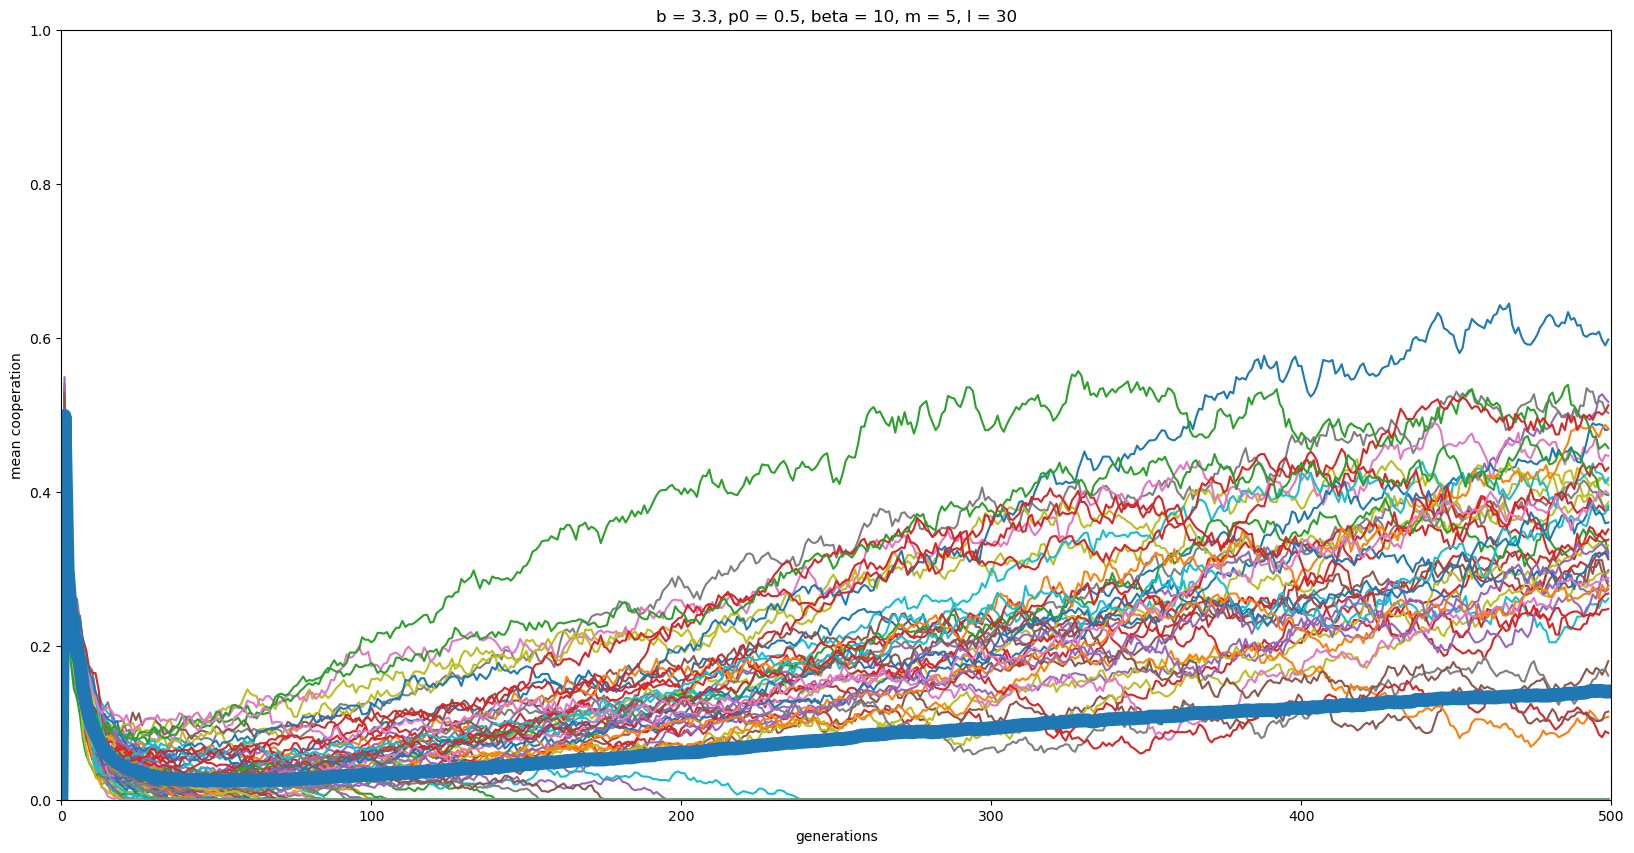

In [ ]:


beta = 10
m = 5
p0 = 0.5
b = 3.3


l = 30
N = l**2
generationsNum = 500
strategies = np.zeros((l,l))
strategies = np.ones((l,l))*(np.random.uniform(0,1,size=(l,l))<p0)
meanFirstCluster ,meanSecondClusters = 0,0


memory = np.ones((l,l,1,2),dtype=np.float64) 
record = np.zeros((l,l,generationsNum,2),dtype=np.float64)
indexMatrix = getIndexMatrix(l)
iterations = 100
datas = np.zeros((iterations,generationsNum))
for i in range(iterations):
    strategies = np.ones((l,l))*(np.random.random(size=(l,l))<p0)
    memory = np.zeros((l,l,1,2),dtype=np.float64) 
    record = np.zeros((l,l,generationsNum,2),dtype=np.float64)
    for t in range(1,generationsNum):

        
        strategies,record,memory = stepLogic(strategies,record,memory,m,t,b,beta,l)
        
    data = np.sum(record[:,:,:,0],axis=(0,1))/(l*l)
    datas[i,:] = data
    firstCluster ,secondClusters = largestAndSecondLargestCluster(strategies.astype(np.int64))
    meanSecondClusters += secondClusters
    meanFirstCluster += firstCluster
    

mean = np.mean(datas,axis=0)      
meanSecondClusters /= iterations
meanFirstCluster /= iterations
print("meanFirstCluster = ",meanFirstCluster)
print("mean Second Cluster = ",meanSecondClusters)


plt.figure(figsize=(20,10))
plt.title('b = '+str(b)+', p0 = '+str(p0)+', beta = '+str(beta)+', m = '+str(m)+ ", l = "+str(l))
plt.xlabel('generations')
plt.ylabel('mean cooperation')
plt.xlim((0,generationsNum))
plt.ylim((0,1))
for i in range(iterations):
    plt.plot(np.arange(generationsNum),datas[i,:])
    

largest , secondLargest = largestAndSecondLargestCluster(strategies)
print(largest,secondLargest)


plt.plot(np.arange(generationsNum),mean,lw= 10)

In [15]:
probOfSurviving = np.mean(datas[:,-1]!=0)
probOfSurviving

0.41

In [16]:
p0 = 0.50
m = 5
beta = 10
l=32
bs = np.arange(20,50)/10
finalCooperativesRatio = np.zeros(bs.shape)
probOfSurviving = np.zeros(bs.shape)
for i in range(bs.shape[0]):
    b = bs[i]
    finalCooperativesRatio[i],probOfSurviving[i] = getResults(p0,b,m,beta,l)
    print(finalCooperativesRatio[i],probOfSurviving[i])

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.003232421875 0.05
0.121337890625 0.37
0.535009765625 0.84
0.73119140625 0.94
0.841416015625 0.98
0.919248046875 1.0
0.961298828125 1.0
0.98685546875 1.0
0.99560546875 1.0
0.999052734375 1.0
0.99966796875 1.0
0.999833984375 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0


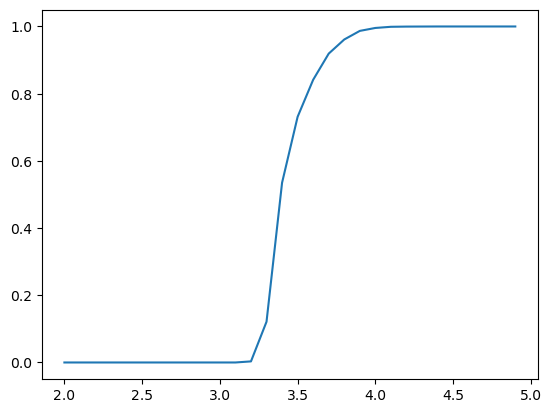

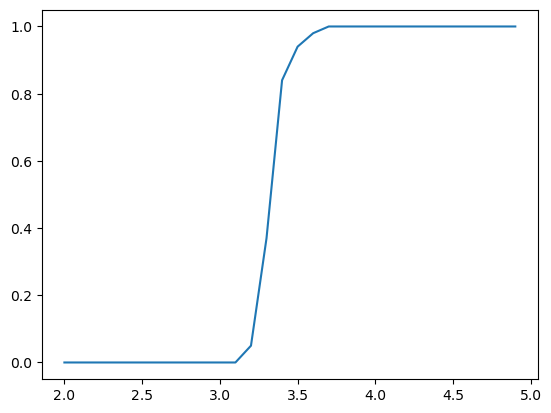

In [17]:
plt.plot(bs,finalCooperativesRatio)
plt.show()
plt.plot(bs,probOfSurviving)
plt.show()

In [24]:
def plotFinalCooperativesRatioAndProbOfSurviving(p0,m,beta,bs,l):
    finalCooperativesRatio = np.zeros(bs.shape)
    probOfSurviving = np.zeros(bs.shape)
    for i in range(bs.shape[0]):
        b = bs[i]
        finalCooperativesRatio[i],probOfSurviving[i],_,_ = getResults(p0,b,m,beta,l)
        print(finalCooperativesRatio[i],probOfSurviving[i])

    plt.title(f"bsVsFinalCooperativesRatioForP0={p0}_m={m}_beta={beta}_l={l}")
    plt.xlabel("bs")
    plt.ylabel("finalCooperativesRatio")
    plt.plot(bs,finalCooperativesRatio)
    plt.show()
    plt.savefig(f"bsVsFinalCooperativesRatioForP0={p0}_m={m}_beta={beta}_l={l}")


    plt.title(f"bsVsProbOfSurvivingForP0={p0}_m={m}_beta={beta}_l={l}")
    plt.xlabel("bs")
    plt.ylabel("probOfSurviving")
    plt.plot(bs,probOfSurviving)
    plt.show()
    plt.savefig(f"bsVsProbOfSurvivingForP0={p0}_m={m}_beta={beta}_l={l}")



In [25]:
def getFinalCooperativesRatioAndProbOfSurviving(p0,m,beta,bs,l):
    finalCooperativesRatio = np.zeros(bs.shape)
    probOfSurviving = np.zeros(bs.shape)
    for i in range(bs.shape[0]):
        b = bs[i]
        finalCooperativesRatio[i],probOfSurviving[i],_,_ = getResults(p0,b,m,beta,l)
        print(finalCooperativesRatio[i],probOfSurviving[i])
        if finalCooperativesRatio[i] != 0:
            print(bs[i])
            bs1 = np.arange(100*bs[i]-10,100*bs[i]+0.1)/100
            finalCooperativesRatio1 = np.zeros(bs1.shape)
            probOfSurviving1 = np.zeros(bs1.shape)
            for j in range(bs1.shape[0]):
                b = bs1[j]
                finalCooperativesRatio1[j],probOfSurviving1[j],_,_ = getResults(p0,b,m,beta,l)
                print(finalCooperativesRatio1[j],probOfSurviving1[j])
                if finalCooperativesRatio1[j] != 0:
                    print(bs1[j])
                    bs2 = np.arange(1000*bs1[j]-10,1000*bs1[j]+0.1)/1000
                    finalCooperativesRatio2 = np.zeros(bs2.shape)
                    probOfSurviving2 = np.zeros(bs2.shape)
                    for k in range(bs2.shape[0]):
                        b = bs1[k]
                        finalCooperativesRatio2[k],probOfSurviving2[k],_,_= getResults(p0,b,m,beta,l)
                        print(finalCooperativesRatio2[k],probOfSurviving2[k])
                        if finalCooperativesRatio2[k] != 0:
                            print(bs2[k])
                            break
                    break
            break

                
        
    # plt.plot(bs,finalCooperativesRatio)
    # plt.show()
    # plt.plot(bs,probOfSurviving)
    # plt.show()
    
    for i in range(bs.shape[0]):
        if finalCooperativesRatio2[i] != 0:
            criticalB = bs[i]
            break
    return finalCooperativesRatio,probOfSurviving,criticalB

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.001640625 0.02
3.2
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.00267578125 0.04
3.18
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
9.765625e-05 0.01
3.176
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.00474609375 0.05
0.16361328125 0.48
0.50130859375 0.78
0.74583984375 0.95
0.8575390625 1.0
0.919130859375 1.0
0.962607421875 1.0
0.986826171875 1.0
0.995830078125 1.0
0.998818359375 1.0
0.99984375 1.0
0.999951171875 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0


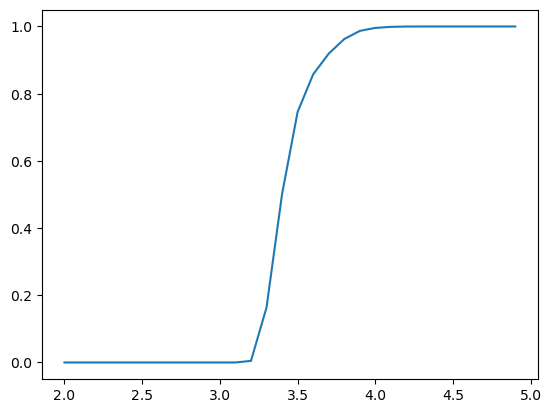

AttributeError: module 'matplotlib.pyplot' has no attribute 'save'

In [20]:
getFinalCooperativesRatioAndProbOfSurviving(0.5,5,10,bs,32)


0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0065625 0.06
0.177177734375 0.56
0.52552734375 0.82
0.744765625 0.96
0.85419921875 0.99
0.921669921875 1.0
0.961982421875 1.0
0.983759765625 1.0
0.995341796875 1.0
0.999169921875 1.0
0.99974609375 1.0
0.999931640625 1.0
1.0 1.0
0.99998046875 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0


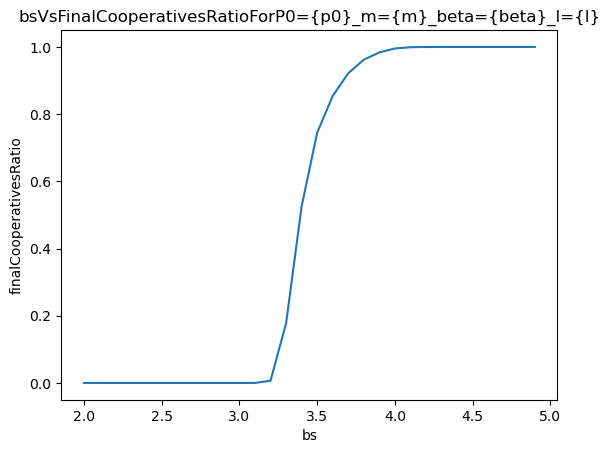

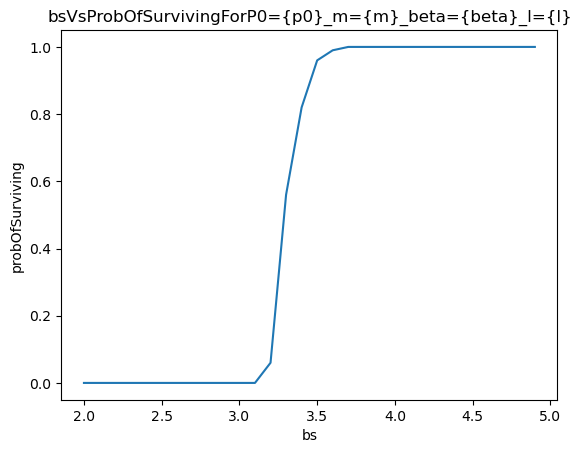

<Figure size 640x480 with 0 Axes>

In [22]:

plotFinalCooperativesRatioAndProbOfSurviving(0.5,5,10,bs,32)

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.001845703125 0.02
3.8
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.001015625 0.02
3.76
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.00029296875 0.01
3.755


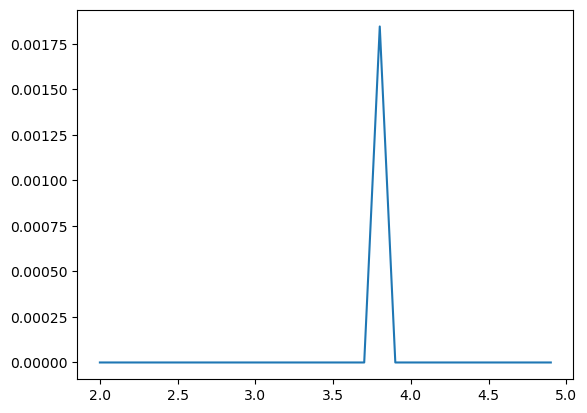

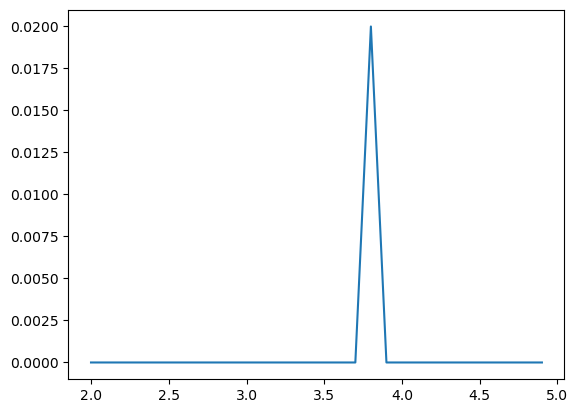

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0014453125 0.02
3.5
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0001953125 0.01
3.46
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.000458984375 0.01
3.458


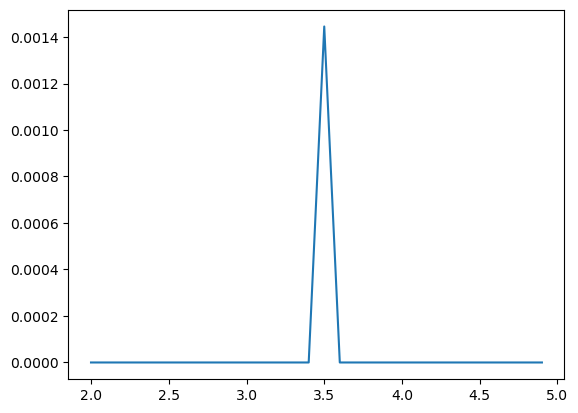

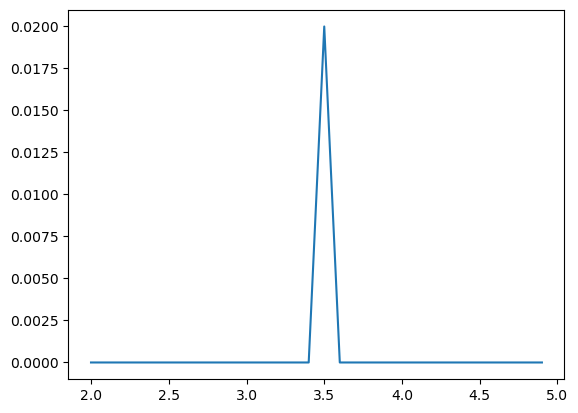

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.013935546875 0.13
3.4
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.001611328125 0.02
3.36
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.00109375 0.02
3.354


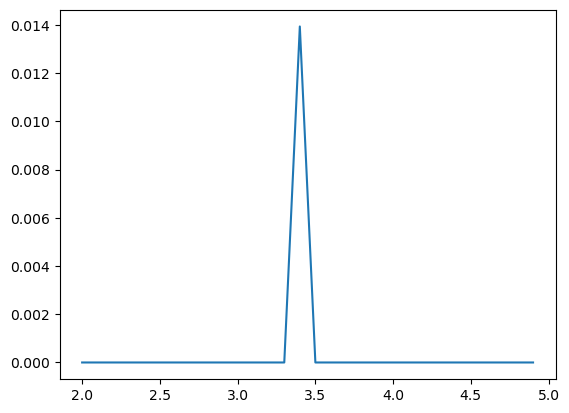

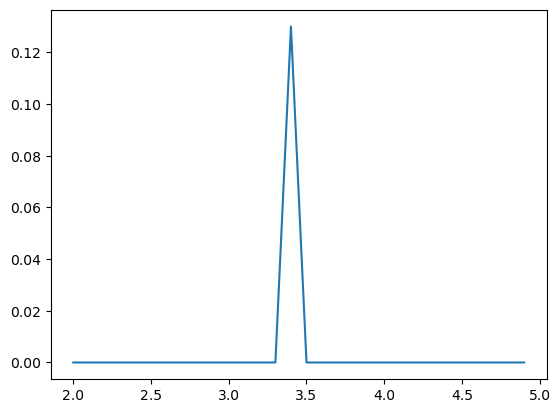

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.016796875 0.13
3.3
0.0 0.0
0.000458984375 0.01
3.21
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.000537109375 0.01
3.205


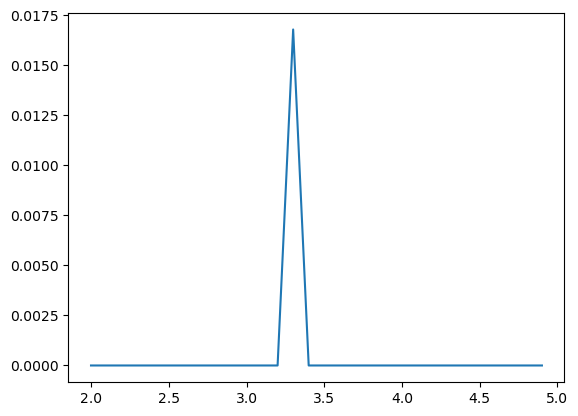

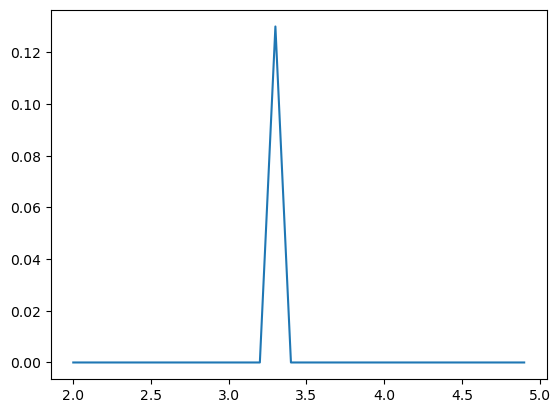

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.002685546875 0.05
3.2
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0001953125 0.01
3.14
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0003125 0.01
3.135


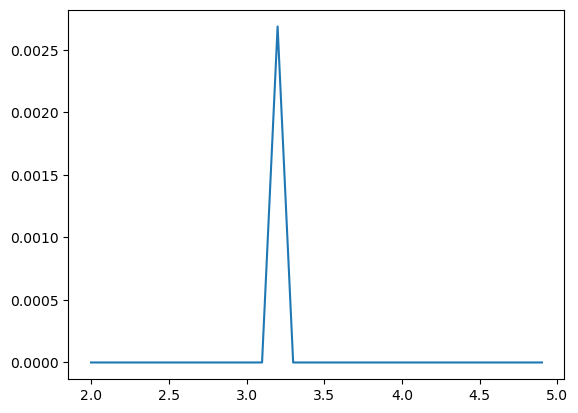

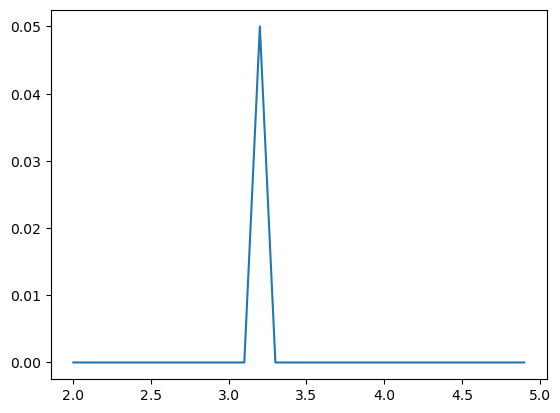

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.051806640625 0.33
3.2
0.001845703125 0.02
3.1
0.000390625 0.01
3.09


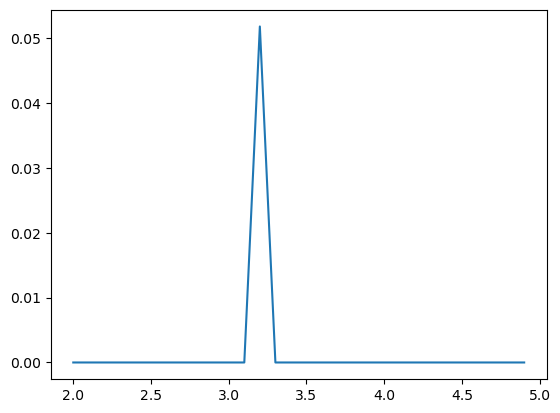

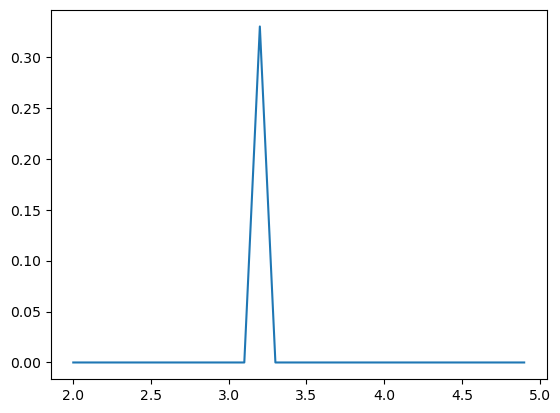

In [22]:
mDatas = np.zeros((6,3))
ms = [1,2,3,4,5,6]
for i in range(len(ms)):
    m = ms[i]
    
    mDatas[i] = getFinalCooperativesRatioAndProbOfSurviving(0.5,m,10,bs,32)
    plotFinalCooperativesRatioAndProbOfSurviving(0.5,m,10,bs,32)

print(mDatas)

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.008100000000000001 0.04
0.10945000000000002 0.22
0.28925 0.43
0.5587999999999999 0.72
0.7100749999999999 0.83
0.7880250000000001 0.86
0.9248000000000003 0.96
0.9822000000000002 1.0
0.9757499999999999 0.98
0.9987750000000001 1.0
1.0 1.0


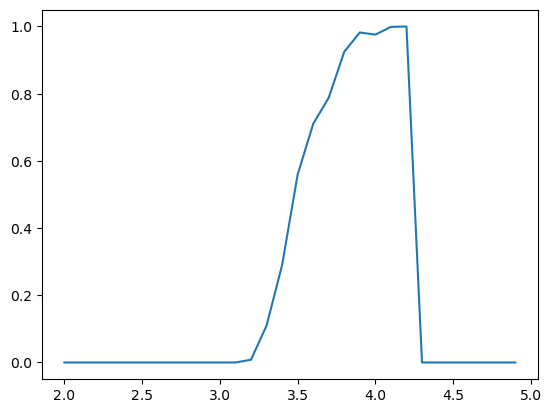

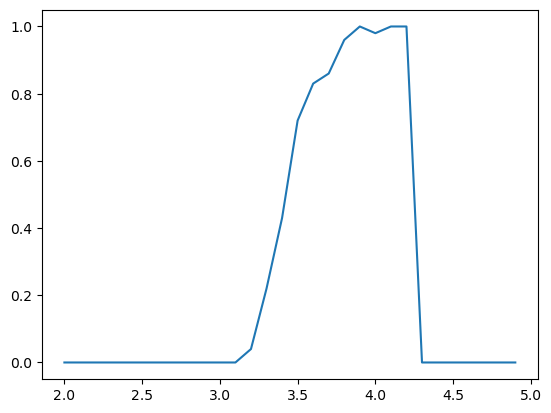

3.2
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0033625 0.05
0.17591874999999998 0.7
0.5650562499999997 0.97
0.7701812500000003 1.0
0.85576875 1.0
0.921175 1.0
0.9607687500000002 1.0
0.9840812499999998 1.0
0.9958625000000005 1.0
0.9991000000000005 1.0
0.9997750000000001 1.0
0.9999625000000001 1.0
1.0 1.0


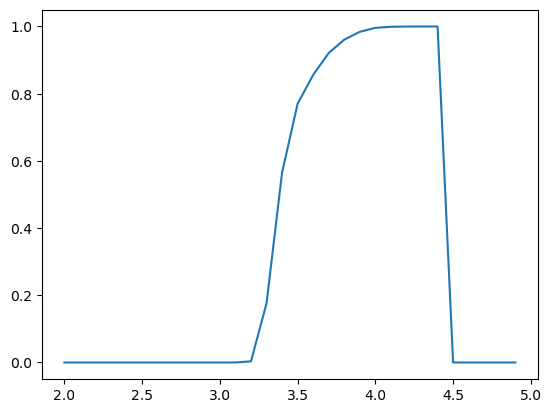

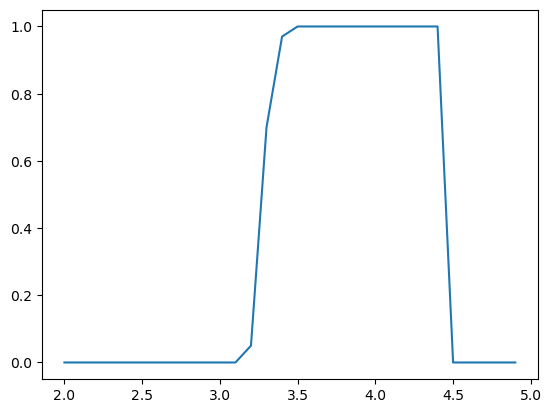

3.2
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0032959999999999995 0.11
0.13482400000000003 0.78
0.5309679999999998 0.98
0.7721160000000001 1.0
0.8602080000000001 1.0
0.9213959999999999 1.0
0.9604360000000004 1.0
0.9863719999999999 1.0
0.995704 1.0
0.999096 1.0
0.999848 1.0
0.9999400000000002 1.0
1.0 1.0


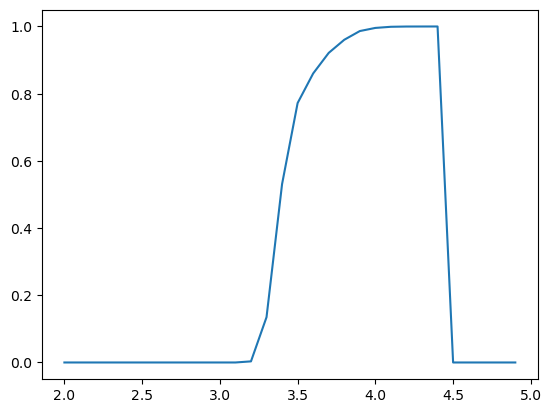

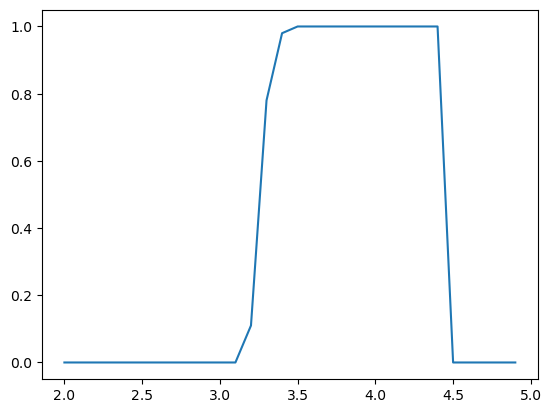

3.2
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0019444444444444442 0.12
0.16170833333333326 0.93
0.5588916666666668 1.0
0.7650388888888889 1.0
0.8593805555555558 1.0
0.9204611111111112 1.0
0.9607777777777774 1.0
0.985172222222223 1.0
0.995163888888889 1.0
0.9988000000000006 1.0
0.9997861111111113 1.0
0.9999527777777779 1.0
1.0 1.0


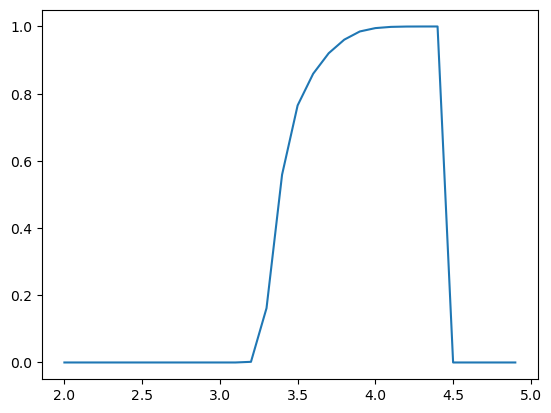

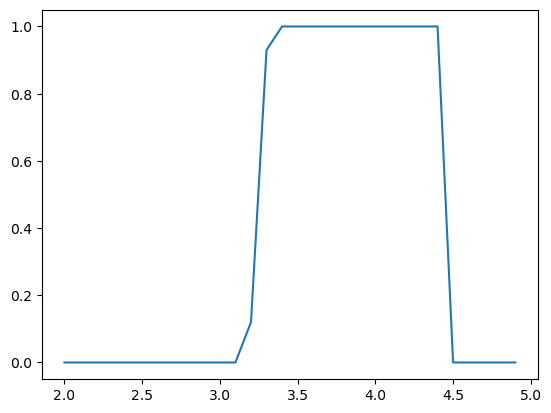

3.2
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.005755102040816326 0.26
0.1604448979591837 0.98
0.5295265306122449 1.0
0.7680346938775509 1.0
0.8585857142857145 1.0
0.9197755102040819 1.0
0.9625755102040818 1.0
0.9855632653061221 1.0
0.9947632653061228 1.0
0.9989020408163267 1.0
0.9998102040816326 1.0
0.9999755102040815 1.0
1.0 1.0


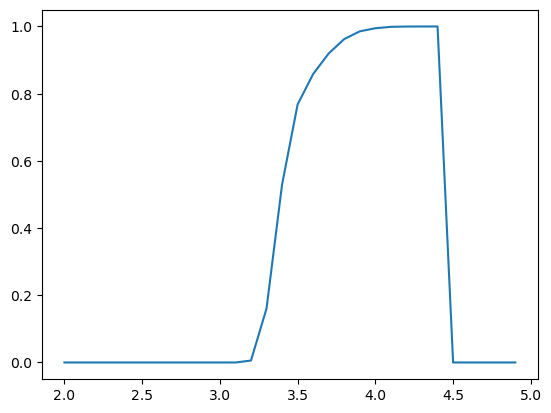

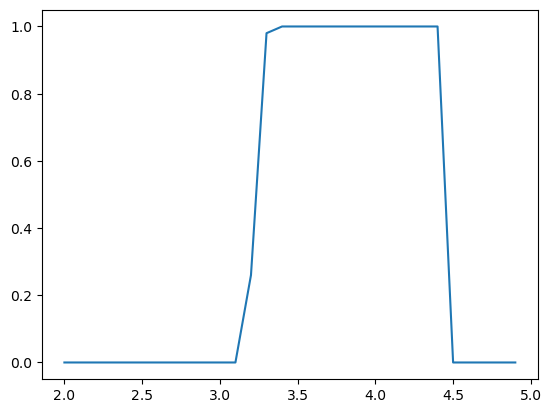

3.2


In [19]:
lData = np.zeros(5,5)
ls = [20,40,50,60,70]
for i in range(5):
    l = ls[i]
    lData[i] = getFinalCooperativesRatioAndProbOfSurviving(0.5,5,10,bs,l)
    print("critcalB = ", criticalB)

print(lData)